In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!kaggle datasets download -d gti-upm/leapgestrecog




Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
leapgestrecog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/leapgestrecog.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install mediapipe
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import os
import mediapipe as mp
from keras.models import load_model

In [ ]:
def load_data(dataset_path):
    X = []
    y = []
    gesture_folders = sorted(os.listdir(dataset_path))
    gesture_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}

    for gesture_folder in gesture_folders:
        gesture_images_path = os.path.join(dataset_path, gesture_folder)
        for subject_folder in os.listdir(gesture_images_path):
            subject_images_path = os.path.join(gesture_images_path, subject_folder)
            for image_name in os.listdir(subject_images_path):
                image_path = os.path.join(subject_images_path, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, (64, 64))
                    X.append(image)
                    y.append(gesture_map[gesture_folder])
                else:
                    print(f"Failed to load image: {image_path}")

    X = np.array(X)
    y = np.array(y)
    return X, y, gesture_map


In [ ]:
# Load data from all folders
dataset_path = '/content/leapGestRecog'  # Replace with your dataset path
X, y, gesture_map = load_data(dataset_path)

In [ ]:
# Normalize the images
X = X / 255.0

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(gesture_map), activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32,
          validation_data=(X_test, y_test))


Epoch 1/30
500/500 [==============================] - 4s 7ms/step - loss: 0.0230 - accuracy: 0.9893 - val_loss: 0.0162 - val_accuracy: 0.9900
Epoch 2/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0126 - accuracy: 0.9921 - val_loss: 0.0117 - val_accuracy: 0.9918
Epoch 3/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0108 - accuracy: 0.9929 - val_loss: 0.0120 - val_accuracy: 0.9923
Epoch 4/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0110 - accuracy: 0.9929 - val_loss: 0.0115 - val_accuracy: 0.9923
Epoch 5/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0111 - accuracy: 0.9918 - val_loss: 0.0120 - val_accuracy: 0.9918
Epoch 6/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0108 - accuracy: 0.9926 - val_loss: 0.0113 - val_accuracy: 0.9915
Epoch 7/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0108 - accuracy: 0.9927 - val_loss: 0.0130 - val_accuracy: 0.9923
Epoch 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


125/125 [==============================] - 1s 3ms/step - loss: 0.0119 - accuracy: 0.9918
Test accuracy: 0.9917500019073486


In [ ]:
# Function to make a prediction on a single image
def make_prediction(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    image = np.expand_dims(image, axis=0) / 255.0

    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)

    # Find the gesture name corresponding to the predicted index
    predicted_gesture_name = [gesture for gesture,idx in gesture_map.items() if idx == predicted_class_index][0]

    return predicted_gesture_name

In [ ]:
model.save('HGR_model.keras')  # Save the entire model including architecture and weights



In [ ]:
from keras.models import load_model

# Load the trained model from file
model = load_model('/content/HGR_model.keras')

# Now you can use 'model' to make predictions


In [ ]:
# Define your gesture mapping dictionary
# This should match the mapping used during training
gesture_map = {
    'palm': 0,
    'thumb': 1,
    'index': 2,
    'fist':3,
}

In [ ]:
import matplotlib.pyplot as plt

def predict_and_display(model, test_image, gesture_map):
    # Display the test image
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Preprocess the image as you did for training before making a prediction
    processed_image = preprocess_image(test_image)  # Replace with your preprocessing function

    # Get prediction - model.predict_classes is deprecated, so use np.argmax(model.predict(...), axis=-1)
    prediction = np.argmax(model.predict(processed_image.reshape(1, 64, 64, 3)), axis=-1)[0]

    # Find the corresponding gesture name using the gesture_map
    gesture_name = [name for name, index in gesture_map.items() if index == prediction][0]

    print(f"Predicted gesture: {gesture_name}")


In [ ]:
# Helper function to preprocess the image (you'll need to define this based on your model's requirements)
def preprocess_image(image):
    # Example: Resize image to 64x64 pixels and normalize pixel values to [0,1]
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    return image


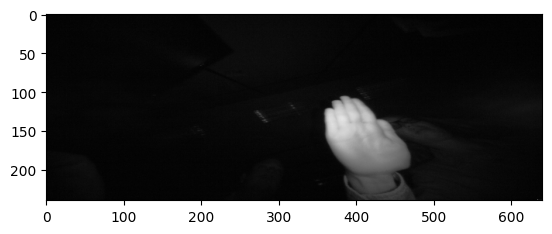

1/1 [==============================] - 0s 30ms/step
Predicted gesture: palm


In [ ]:
# Example usage:
# Load and preprocess your test image here as per your model's requirements
test_image = cv2.imread('/content/leapGestRecog/00/01_palm/frame_00_01_0001.png')
predict_and_display(model, test_image, gesture_map)